In [22]:
from __future__ import division, print_function, unicode_literals

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import seaborn as sns
sns.set(font_scale = 1.4)

In [23]:
#importing data
frauddf = pd.read_csv("C:/Users/paulb/Documents/DSBA_6156_Final_Project/DSBA6156_FP/PS_20174392719_1491204439457_log.csv")

In [24]:
#Head of dataset
frauddf.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [25]:
#Adding binary for transaction type
trans = pd.get_dummies(frauddf.type)
frauddf = frauddf.join(trans)
frauddf.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,0,1,0


In [26]:
#Check of data shape
frauddf.shape

(6362620, 16)

In [27]:
#Adding binary for Dest type
nameDestC = frauddf.nameDest.str.startswith("C")
frauddf["nameDestC"] = nameDestC.astype(int)
frauddf.nameDestC.unique()

frauddf = frauddf.drop(['isFlaggedFraud', 'CASH_IN', 'DEBIT', 'PAYMENT', 
                        'nameDest', 'nameOrig', 'type'], axis = 1)
print(frauddf.shape)
print(frauddf.columns.values)

(6362620, 10)
['step' 'amount' 'oldbalanceOrg' 'newbalanceOrig' 'oldbalanceDest'
 'newbalanceDest' 'isFraud' 'CASH_OUT' 'TRANSFER' 'nameDestC']


In [28]:
#Checking and creating dummy variables
frauddf.dtypes

frauddf['isFraud'] = frauddf['isFraud'].astype('category')
frauddf['TRANSFER'] = frauddf['TRANSFER'].astype('category')
frauddf['CASH_OUT'] = frauddf['CASH_OUT'].astype('category')
frauddf['nameDestC'] = frauddf['nameDestC'].astype('category')

In [29]:
#Developing Trim Model
#Conditions of trimmed dataset
trim1 = frauddf.TRANSFER == 1
trim2 = frauddf.CASH_OUT == 1
trimcond = trim1 | trim2

#Forming final trimmed dataset
trimdf = frauddf[trimcond]
trimdf = trimdf.drop(['CASH_OUT', 'nameDestC'], axis = 1)
print(trimdf.shape)
print(trimdf.columns.values)

(2770409, 8)
['step' 'amount' 'oldbalanceOrg' 'newbalanceOrig' 'oldbalanceDest'
 'newbalanceDest' 'isFraud' 'TRANSFER']


In [30]:
#Labeling target column
labels = np.array(frauddf['isFraud'])

#Removing variable names from dataset
frauddf= frauddf.drop('isFraud', axis=1)

#Saving variable names for later use
frauddf_target = list(frauddf.columns)

#Converting dataframe to numpy array
fraudarray = np.array(frauddf)

In [31]:
#Importing train-test-split
from sklearn.model_selection import train_test_split

#Splitting data
train_fraudarray, test_fraudarray, train_labels, test_labels = train_test_split(fraudarray, labels, test_size = 0.33, random_state = 42) 

In [32]:
#Rechecking the shape
print('Training Fraud Array Shape', train_fraudarray.shape)
print('Training Label Shape', train_labels.shape)
print('Testing Fraud Array Shape', test_fraudarray.shape)
print('Testing Label Shape', test_labels.shape)

Training Fraud Array Shape (4262955, 9)
Training Label Shape (4262955,)
Testing Fraud Array Shape (2099665, 9)
Testing Label Shape (2099665,)


In [33]:
#Run Random Forest Model
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(train_fraudarray, train_labels)

y_pred_rf = rnd_clf.predict(test_fraudarray)

In [34]:
#Calculate the absolute errors
errors = abs(y_pred_rf - test_labels)
print('Absolute Errors:', sum(errors))

#Print out the mean absolute error (mae)
print('Mean Square Error:', np.mean(errors ** 2))

Absolute Errors: 606
Mean Square Error: 0.0002886174699297269


In [35]:
#Accuracy
np.sum(test_labels == y_pred_rf) / len(test_labels)

0.9997113825300703

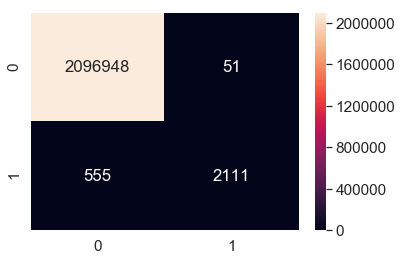

In [36]:
#Confusion Matrix
cm = confusion_matrix(test_labels, y_pred_rf)
A = cm[0, 0]
B = cm[0, 1]
C = cm[1, 0]
D = cm[1, 1]
labels = np.array([[A, B], [C, D]])
sns.heatmap(cm, annot = labels, fmt = '')

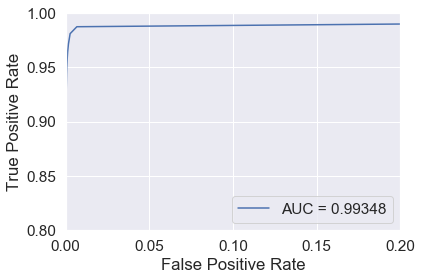

In [37]:
#ROC Curve
#Developing values for curve
y_pred_rf_prob = rnd_clf.predict_proba(test_fraudarray)[:, 1]
fpr, tpr, _ = roc_curve(test_labels, y_pred_rf_prob)
roc_auc = auc(fpr, tpr)

#Visualizing values

plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [38]:
#Labeling target column
trimlabels = np.array(trimdf['isFraud'])

#Removing variable names from dataset
trimdf = trimdf.drop('isFraud', axis=1)

#Saving variable names for later use
trimdf_target = list(trimdf.columns)

#Converting dataframe to numpy array
trimarray = np.array(trimdf)

In [39]:
#Splitting data
train_trimarray, test_trimarray, train_trimlabels, test_trimlabels = train_test_split(trimarray, trimlabels, test_size = 0.33, random_state = 42) 

In [40]:
#Check on sample set sizes
print('Training Fraud Array Shape', train_trimarray.shape)
print('Training Label Shape', train_trimlabels.shape)
print('Testing Fraud Array Shape', test_trimarray.shape)
print('Testing Label Shape', test_trimlabels.shape)

Training Fraud Array Shape (1856174, 7)
Training Label Shape (1856174,)
Testing Fraud Array Shape (914235, 7)
Testing Label Shape (914235,)


In [41]:
#Run Random Forest Model
rnd_clftrim = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clftrim.fit(train_trimarray, train_trimlabels)

y_pred = rnd_clftrim.predict(test_trimarray)

In [43]:
# Calculate the absolute errors
errors1 = abs(y_pred - test_trimlabels)
print('Absolute Error:', sum(errors1))

# Print out the mean absolute error (mae)
print('Mean Square Error:', np.mean(errors1 ** 2))

Absolute Error: 657
Mean Square Error: 0.0007186336117081494


In [44]:
#Accuracy
np.sum(test_trimlabels == y_pred) / len(test_trimlabels)

0.9992813663882919

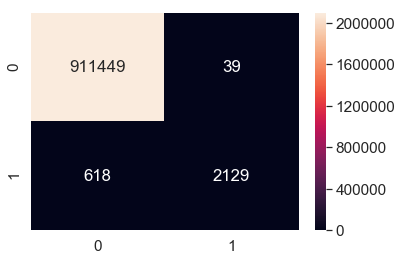

In [45]:
#Confusion Matrix
cm1 = confusion_matrix(test_trimlabels, y_pred)
A = cm1[0, 0]
B = cm1[0, 1]
C = cm1[1, 0]
D = cm1[1, 1]
labels = np.array([[A, B], [C, D]])
sns.heatmap(cm, annot = labels, fmt = '')

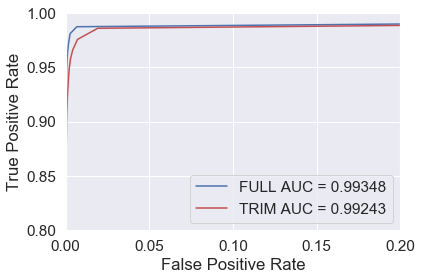

In [46]:
#ROC Curve
#Developing values for curve
y_pred_prob = rnd_clftrim.predict_proba(test_trimarray)[:, 1]
fpr_trim, tpr_trim, _ = roc_curve(test_trimlabels, y_pred_prob)
roc_auc_trim = auc(fpr_trim, tpr_trim)

#Visualizing values
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr, tpr, 'b', label = 'FULL AUC = %0.5f' % roc_auc)
plt.plot(fpr_trim, tpr_trim, 'r', label = 'TRIM AUC = %0.5f' % roc_auc_trim)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()